## Q1
Linear Discriminant Analysis (25 Points) After loading your training data, fit LDA classifiers (using all 11 continuous features to predict wine quality) under the following scenarios

(a) Non-informative (flat) priors on wine quality

(b) Priors that reflect the observed proportion of wines at different quality levels.

(c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are good (your choice for specific values.)

(d) Priors that somebody with terrible taste in wine would use (i.e. most wines are good, few wines are bad or average).

In each case, calculate the overall mis-classification rate and present a cross-tabs table showing which categories are being classified correctly vs. incorrectly in your training dataset. (Note, do not present pair-plots here, the dimensionality is too high.) Next, for each prior, apply your LDA model to the testing dataset, and present the mis-classification rate and cross-tabs.

Discuss the performance of your LDA models under your various choices of priors. How does the
performance change when we start testing our models on the testing data?

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

In [2]:
train = pd.read_csv("data/whitewine-training-ds6040.csv")
train.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C


In [3]:
test = pd.read_csv("data/whitewine-testing-ds6040.csv")
test.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,2.074706,2.095780,-0.370398,-0.442945,-0.924246,-0.963499,-0.878403,-0.770506,-1.210376,-0.994742,1.581632,F
1,0.752463,0.031237,0.597571,-1.000570,-0.077157,-1.447827,-0.290673,-0.380327,0.659670,-0.373157,-0.151371,F
2,-1.050596,-0.170181,0.032922,-1.000570,0.016964,-1.750531,-2.571065,-0.563331,0.728931,1.225203,-0.068847,F
3,-1.892024,1.541879,-1.822352,-1.040400,-0.783065,-1.750531,-2.053863,-1.129610,2.252672,-0.106764,0.591345,F
4,-0.569781,-0.371600,-0.370398,1.010863,0.252266,-0.176466,0.649694,0.955952,0.867453,-0.373157,-0.811562,F


In [4]:
class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

#### Q1-A
(a) Non-informative (flat) priors on wine quality

In [5]:
## Non informative priors on wine
flat_priors_lda = LDA(train, 'wine_quality')

In [6]:
## Misclassification rate for train data
flat_priors_lda.misclass_rate()

0.49496538703587156

The misclassifcation is around 49%, which can be high in some aspects. We can take a look at the truth table to gain more info about the misclassifications

In [7]:
## Truth Table
flat_priors_lda.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,69,687,62
C,22,800,202
F,9,591,736


We can also see how this model generalizes to the test dataset.

In [8]:
flat_priors_lda.misclass_rate(data = test)

0.48546511627906974

Again, the misclass rate is very high and almost exactly the same as the training set. 

In [9]:
flat_priors_lda.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,56,348,43
C,15,381,149
F,9,271,448


From the confusion matrix (xtabs) we can see that the many instances of the C class were classified evenly between A, C , and F. A and F were relativly correctly classified.

#### Q1-B
(b) Priors that reflect the observed proportion of wines at different quality levels.

In [10]:
## Collecting information about proportion of wine levels
train["wine_quality"].value_counts(normalize=True)

C    0.653870
F    0.314663
A    0.031466
Name: wine_quality, dtype: float64

In [11]:
proportion = train["wine_quality"].value_counts(normalize=True)
reorder_prop = [proportion[2], proportion[0], proportion[1]]
prop_priors_lda = LDA(train, 'wine_quality', priors=reorder_prop)

In [12]:
prop_priors_lda.misclass_rate()

0.28099433606041535

Compared to the original training error for the flat priors, we can see that it has imporved a lot with a misclassifcation rate at around 28%.

In [13]:
prop_priors_lda.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,0,0,1
C,100,1913,627
F,0,165,372


When using the proportions of the classes, we can see that almost none of the A class instances were classified as A while C and F performed relativly better. This could be because of such low proportions for the A class. 

Now, we must check how it generalizes with the testing set. 

In [14]:
prop_priors_lda.misclass_rate(data = test)

0.32732558139534884

In [15]:
prop_priors_lda.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
C,79,923,406
F,1,77,234


Although the misclass rate was 0.3, we can see that there were no predictions for the A Class. A 100% of the True A class was misclassified along with F being classified as mostly C, which may come from the high proportions of the C class in the dataset, which we utilized for priors.

For the proportions of wines as priors showed much more promise with the test and training errors decreasing compared to non informative priors. We can also see the classic nature of test error being worse than the training error, which was not observed in the non informative priors.

#### Q1-C
(c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are good (your choice for specific values.)

This is from personal experience, which aligns well with what is asked for in the problem statment. I've experienced that most (~70%) of wines are aweful. 20% is average. 10% is good.

In [16]:
personal_priors = LDA(train, 'wine_quality', priors=[0.1, 0.2, 0.7])

In [17]:
personal_priors.misclass_rate()

0.5972309628697294

The misclassification rate for my personal priors turned out to be pretty aweful with a misclassificatino rate of around 59%

In [18]:
personal_priors.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,38,196,6
C,14,266,18
F,48,1616,976


The cross table shows that for most classes the mapping was set for the F class. The F class did great, but this is probably due to the high prior we set for the F class (0.7)

Below is the generalization of the model to the testing set. 

In [19]:
personal_priors.misclass_rate(data = test)

0.5505813953488372

In [20]:
personal_priors.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,25,123,4
C,11,126,14
F,44,751,622


We again, see what we observed in the cross table for the training data where most cases were classified as F.

Interstingly enough, similar to non informative priors, the testing error was lower than the training error. Regardless, selecting a personal prior showed to have a high training and testing error similar to the behavior of the non informative prior.

#### Q1-D
(d) Priors that somebody with terrible taste in wine would use (i.e. most wines are good, few wines are bad or average).

For this situation we will assume a person with terrible taste in wine will say that most (70%) of wine is good while 15% is good and 15% is aweful.

In [21]:
bad_taste_priors = LDA(train, 'wine_quality', priors=[0.7, 0.15, 0.15])

In [22]:
bad_taste_priors.misclass_rate()

0.8077407174323474

In [23]:
bad_taste_priors.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,93,1765,488
C,0,12,6
F,7,301,506


The misclassifcation rate for the training data was very high, which aligns well since someone that says most wine is good probably has no idea what wine tastes like.

We can again see the importance of prior setting when training the LDA function. Since our A class was set as 0.7, many instances of the data were classified as A, which is good for the A class, but not so well for the C and F class.

Now to generalize this to the test set

In [24]:
bad_taste_priors.misclass_rate(data = test)

0.7744186046511627

In [25]:
bad_taste_priors.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,76,853,326
C,0,5,7
F,4,142,307


This prior had a lower mis classifcation that the training rate, which is opposite of what normally is observed. Regardless, it is still very high.

Also, the behavior we saw from the cross table of the training misclass rate was present in the testing set as well.

## Q2
(25 Points) Fit LDA models for each combination of 3 features (loop over all combinations of 3 features,
there will be 165 combinations). Use flat priors on wine quality.

(a) For each model, extract the overall miss-classification rate for both the training and the testing
dataset. Which combination of three features provides the lowest miss-classification rate for the
testing and training datasets? Are they the same or different (between the training/testing)? For the
best performing models (for training and testing), using the functions provided, provide pair-plots
for mis-classification.

(b) Using priors that reflect the observed proportion of wine quality in the training dataset, identify the
combination of three features that provide the lowest mis-classification rate. Do the best models
differ from when you used flat priors?

In [26]:
import itertools
## print first 5 combinations
count = 0
for i in itertools.combinations(train.columns[:-1], 3):
    print(i)
    count = count + 1
    if count > 5:
        break

('fixed.acidity', 'volatile.acidity', 'citric.acid')
('fixed.acidity', 'volatile.acidity', 'residual.sugar')
('fixed.acidity', 'volatile.acidity', 'chlorides')
('fixed.acidity', 'volatile.acidity', 'free.sulfur.dioxide')
('fixed.acidity', 'volatile.acidity', 'total.sulfur.dioxide')
('fixed.acidity', 'volatile.acidity', 'density')


#### Q2-A
(a) For each model, extract the overall miss-classification rate for both the training and the testing dataset. Which combination of three features provides the lowest miss-classification rate for the testing and training datasets? Are they the same or different (between the training/testing)? For the best performing models (for training and testing), using the functions provided, provide pair-plots for mis-classification.

In [27]:
error_rates_combinations = []
for i in itertools.combinations(train.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    flat_priors_lda = LDA(train[combination], 'wine_quality')
    training_error = flat_priors_lda.misclass_rate()
    testing_error = flat_priors_lda.misclass_rate(data = test[combination])
    error_rates_combinations.append([",".join(combination[:-1]), training_error, testing_error])
df_error_rates_combinations = pd.DataFrame(error_rates_combinations)
df_error_rates_combinations.columns = ["combinations", "training error", "testing error"]
df_error_rates_combinations

,combinations,training error,testing error
0,"fixed.acidity,volatile.acidity,citric.acid",0.601007,0.581395
1,"fixed.acidity,volatile.acidity,residual.sugar",0.614223,0.593605
2,"fixed.acidity,volatile.acidity,chlorides",0.569855,0.568605
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.601322,0.598837
4,"fixed.acidity,volatile.acidity,total.sulfur.di...",0.612964,0.598837
...,...,...,...
160,"total.sulfur.dioxide,sulphates,alcohol",0.564191,0.549419
161,"density,pH,sulphates",0.667716,0.663372
162,"density,pH,alcohol",0.554751,0.545349
163,"density,sulphates,alcohol",0.560415,0.533140


Lets check what the top 10 combinations were for the highest training error.

In [28]:
df_error_rates_combinations.sort_values(by="training error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.505035,0.488372
77,"volatile.acidity,density,alcohol",0.510699,0.487791
79,"volatile.acidity,pH,alcohol",0.520453,0.515698
52,"volatile.acidity,citric.acid,alcohol",0.523285,0.515116
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.523285,0.500581
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.523600,0.505814
80,"volatile.acidity,sulphates,alcohol",0.524229,0.501163
65,"volatile.acidity,chlorides,alcohol",0.525488,0.511628
56,"volatile.acidity,residual.sugar,density",0.526432,0.519186
8,"fixed.acidity,volatile.acidity,alcohol",0.528005,0.513953


In [29]:
df_error_rates_combinations.sort_values(by="testing error").head(10)

,combinations,training error,testing error
77,"volatile.acidity,density,alcohol",0.510699,0.487791
59,"volatile.acidity,residual.sugar,alcohol",0.505035,0.488372
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.523285,0.500581
80,"volatile.acidity,sulphates,alcohol",0.524229,0.501163
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.523600,0.505814
65,"volatile.acidity,chlorides,alcohol",0.525488,0.511628
8,"fixed.acidity,volatile.acidity,alcohol",0.528005,0.513953
52,"volatile.acidity,citric.acid,alcohol",0.523285,0.515116
79,"volatile.acidity,pH,alcohol",0.520453,0.515698
56,"volatile.acidity,residual.sugar,density",0.526432,0.519186


The top 10 combinations for both testing and training were similar. For most of the combinations, alcohol was present as well as volatile.acidity being present in many combinations as well for both. The absolute best for training and testing were different, but because the training and testing are similar between all combinations from inital inspection it seemed that combination doesn't have a big playing factor.

Best performing in regards to training error was for the combination of volatile.acidity,residual.sugar,alcohol. Here we will create a pair plot for misclassification.

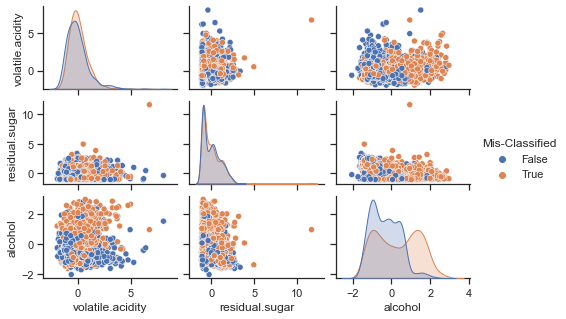

In [30]:
flat_priors_lda = LDA(train[["volatile.acidity", "residual.sugar","alcohol", "wine_quality"]], 'wine_quality')
flat_priors_lda.misclass_pairplot()

In terms for the best performing for testing data was for the combination of volatile.acidity,density,alcohol. The pair plot for misclassification is as follows.

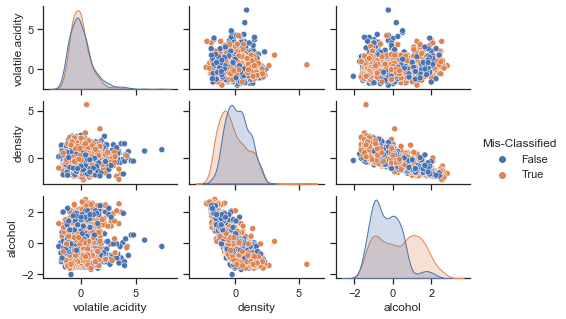

In [31]:
flat_priors_lda = LDA(train[["volatile.acidity","density", "alcohol", "wine_quality"]], 'wine_quality')
flat_priors_lda.misclass_pairplot(data = test[["volatile.acidity","density", "alcohol", "wine_quality"]])

#### Q2-B
(b) Using priors that reflect the observed proportion of wine quality in the training dataset, identify the combination of three features that provide the lowest mis-classification rate. Do the best models differ from when you used flat priors?

In [32]:
error_rates_combinations = []
proportion = train["wine_quality"].value_counts(normalize=True)
reorder_prop = [proportion[2], proportion[0], proportion[1]]
for i in itertools.combinations(train.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    prop_priors_lda = LDA(train[combination], 'wine_quality',priors=reorder_prop)
    training_error = prop_priors_lda.misclass_rate()
    testing_error = prop_priors_lda.misclass_rate(data = test[combination])
    error_rates_combinations.append([",".join(combination[:-1]), training_error, testing_error])
df_error_rates_combinations_prop = pd.DataFrame(error_rates_combinations)
df_error_rates_combinations_prop.columns = ["combinations", "training error", "testing error"]
df_error_rates_combinations_prop

,combinations,training error,testing error
0,"fixed.acidity,volatile.acidity,citric.acid",0.340151,0.403488
1,"fixed.acidity,volatile.acidity,residual.sugar",0.334802,0.400000
2,"fixed.acidity,volatile.acidity,chlorides",0.327565,0.390116
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.335746,0.393605
4,"fixed.acidity,volatile.acidity,total.sulfur.di...",0.329138,0.395349
...,...,...,...
160,"total.sulfur.dioxide,sulphates,alcohol",0.337948,0.402907
161,"density,pH,sulphates",0.354626,0.423837
162,"density,pH,alcohol",0.336375,0.390698
163,"density,sulphates,alcohol",0.337634,0.395930


Checking the top 10 lowest training errors.

In [33]:
df_error_rates_combinations_prop.sort_values(by="training error").head(10)

,combinations,training error,testing error
80,"volatile.acidity,sulphates,alcohol",0.280050,0.331977
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.280365,0.336628
79,"volatile.acidity,pH,alcohol",0.280994,0.333140
65,"volatile.acidity,chlorides,alcohol",0.282253,0.337791
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.282253,0.337791
77,"volatile.acidity,density,alcohol",0.282253,0.330233
52,"volatile.acidity,citric.acid,alcohol",0.282568,0.334302
59,"volatile.acidity,residual.sugar,alcohol",0.282882,0.329651
8,"fixed.acidity,volatile.acidity,alcohol",0.283826,0.331977
56,"volatile.acidity,residual.sugar,density",0.301762,0.359884


Checking to top 10 lowest testing errors.

In [34]:
df_error_rates_combinations_prop.sort_values(by="testing error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.282882,0.329651
77,"volatile.acidity,density,alcohol",0.282253,0.330233
8,"fixed.acidity,volatile.acidity,alcohol",0.283826,0.331977
80,"volatile.acidity,sulphates,alcohol",0.280050,0.331977
79,"volatile.acidity,pH,alcohol",0.280994,0.333140
52,"volatile.acidity,citric.acid,alcohol",0.282568,0.334302
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.280365,0.336628
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.282253,0.337791
65,"volatile.acidity,chlorides,alcohol",0.282253,0.337791
56,"volatile.acidity,residual.sugar,density",0.301762,0.359884


Similar to the non informative priors, we could see voldatile.acidity in all top 10 combinations adn alcohol being in most combinations as well. The best performing from the training error was volatile.acidity,sulphates,alcohol with a training error of 0.280050 and the best performing combination for the testing set was volatile.acidity,residual.sugar,alcohol with a testing error rate of 0.329651. For both combinations volatile.acidity and alcohol were present. 

We will showecase the pair plot misclassifcation for the best performing training error combination.

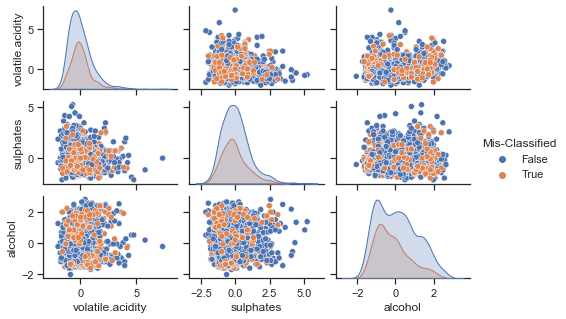

In [35]:
prop_priors_lda = LDA(train[["volatile.acidity","sulphates", "alcohol", "wine_quality"]], 'wine_quality',priors=reorder_prop)
prop_priors_lda.misclass_pairplot(data = test[["volatile.acidity","sulphates", "alcohol", "wine_quality"]])

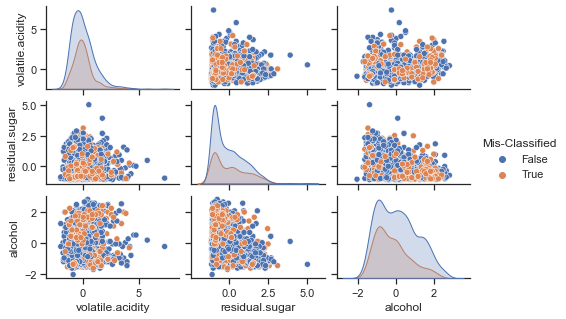

In [36]:
prop_priors_lda = LDA(train[["volatile.acidity","residual.sugar", "alcohol", "wine_quality"]], 'wine_quality',priors=reorder_prop)
prop_priors_lda.misclass_pairplot(data = test[["volatile.acidity","residual.sugar", "alcohol", "wine_quality"]])

## Q3

Quadratic Discriminant Analysis (25 Points) 

Now, fit QDA classifiers (using all 11 continuous features
to predict wine quality) under the following scenarios (NOTE: This problem is identical to the previous,
except now you are using QDA rather than LDA. Copy-paste your code accordingly.)

(a) Non-informative (flat) priors on wine quality

(b) Priors that reflect the observed proportion of wines at different quality levels.

(c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are
good (your choice for specific values.)

(d) Priors that somebody with terrible taste in wine would use (i.e. most wines are good, few wines are
bad or average).

In each case, calculate the overall mis-classification rate and present a cross-tabs table showing
which categories are being classified correctly vs. incorrectly in your training dataset. (Note, do
not present pair-plots here, the dimensionality is too high.)

Next, for each prior, apply your QDA model to the testing dataset, and present the mis-classification
rate and cross-tabs.

Discuss the performance of your QDA models under your various choices of priors. How does the
performance change when we start testing our models on the testing data?

In [37]:
class QDA(LDA):
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps

#### Q3-A
(a) Non-informative (flat) priors on wine quality

In [38]:
flat_priors_qda = QDA(train, 'wine_quality')

In [39]:
flat_priors_qda.misclass_rate()

0.5088105726872247

In [40]:
flat_priors_qda.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,87,828,90
C,9,799,235
F,4,451,675


The misclassifciation rate for a QDA model on the wine dataset with non informative priors was 0.5088105726872247, which is very high and similar to the non informative LDA model, which was 0.49496538703587156.

From the cross table we can see many instances of the C clas were classified as the A class, which may have resulted in a high misclass rate.

Next we will find the error rate against the testing set.

In [41]:
flat_priors_qda.misclass_rate(data=test)

0.5186046511627906

In [42]:
flat_priors_qda.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,58,414,54
C,21,381,197
F,1,205,389


For the QDA model, the testing error was slightly higher than the training error. The LDA model had a smaller testing error for the non informative priors when compared to its respective training rate, but for the QDA model, the testing error was slightly higher for its respective training rate.

Again, the C class was misclassified as the A class for many instances.

#### Q3-B
(b) Priors that reflect the observed proportion of wines at different quality levels.

In [43]:
proportion = train["wine_quality"].value_counts(normalize=True)
reorder_prop = [proportion[2], proportion[0], proportion[1]]
prop_priors_qda = QDA(train, 'wine_quality', priors=reorder_prop)

In [44]:
prop_priors_qda.misclass_rate()

0.27879169288860917

In [45]:
prop_priors_qda.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,20,36,3
C,78,1754,479
F,2,288,518


From the prior information being the proportions we can see that most classifications were for the C class, which is great for the C class, but not so great for the other classes. As one can see most A classes were classified as C. The F class was classified almost equally between C and F.

The prior using the proportion of wines at different quality levels for the QDA model decreased the training rate. In comparision to the LDA model, which had a misclass training rate of 0.28099433606041535, the QDA model performed very slighly better with a training misclasrate of 0.27879169288860917. Regardless, the priors selected based on the proportion of wines served to outperform the non informative prior model. 

In [46]:
prop_priors_qda.misclass_rate(data = test)

0.33255813953488367

In [47]:
prop_priors_qda.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,7,24,1
C,73,842,340
F,0,134,299


The prior using the proportion of wines at different quality levels for the QDA model decreased the testing rate as well. In comparision to the LDA model, which had a misclass training rate of 0.32732558139534884, the QDA model performed very slighly worse with a training misclasrate of 0.33255813953488367. Regardless, the priors selected based on the proportion of wines served to outperform the non informative prior model.

The cross table shows the same behavior with the cross table shown for the training data.

#### Q3-C
(c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are
good (your choice for specific values.)


This is from personal experience, which aligns well with what is asked for in the problem statment. I've experienced that most (~70%) of wines are aweful. 20% is average. 10% is good.

In [48]:
personal_priors = QDA(train, 'wine_quality', priors=[0.1, 0.2, 0.7])

In [49]:
personal_priors.misclass_rate()

0.5210824417872876

In [50]:
personal_priors.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,68,542,44
C,20,592,94
F,12,944,862


Similar to the behavior that we observed in the LDA model, the priors based on someone's opinion performed worse. The training error for the QDA model using these priors were 0.5210824417872876, which was better than the LDA model, which was 0.5972309628697294. 

Also, in regards to the cross table many instances of C were classified to be F, which may have been due to the prior information. However, what is interesting is that the A class was correctly identified for most of its instances. 

In [51]:
personal_priors.misclass_rate(data = test)

0.49534883720930234

In [52]:
personal_priors.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,46,284,18
C,23,275,75
F,11,441,547


When looking at the testing error for the priors based on someone's opinion, the testing error was slighly better than the training error. Again, when comparing to LDA using these priors, the error was better; 0.49534883720930234 for QDA with opinion priors and 0.5505813953488372 for LDA with opinion priors for testing error rate.

#### Q3-D
(d) Priors that somebody with terrible taste in wine would use (i.e. most wines are good, few wines are
bad or average).

For this situation we will assume a person with terrible taste in wine will say that most (70%) of wine is good while 15% is good and 15% is aweful.

In [53]:
bad_taste_priors = QDA(train, 'wine_quality', priors=[0.7, 0.15, 0.15])

In [54]:
bad_taste_priors.misclass_rate()

0.6428571428571428

In [55]:
bad_taste_priors.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,96,1265,222
C,2,405,144
F,2,408,634


Since the prior information had 0.7 for class A many instances were classified as A especially for the C class. 

The qda model with the terrible taste prior had a very high misclassification rate for the training date. Compared to the LDA model, which was 0.8077407174323474 the QDA model performed better, but both QDA and LDA using the bad taste priors were not very helpful.

In [56]:
bad_taste_priors.misclass_rate(data = test)

0.6296511627906977

In [57]:
bad_taste_priors.misclass_xtabs(data = test)

True Class,A,C,F
MAP Class,,,
A,68,617,154
C,11,201,118
F,1,182,368


The testing misclassifcation rate served to be a little better than the training rate, but still around 63%, which is very high. The LDA model test error rate for these priors were 0.7744186046511627. Therefore, the QDA model test training error of 0.6296511627906977 was a little better than LDA, but still not very informative.

## Q4
(25 Points) Fit QDA models for each combination of 3 features (loop over all combinations of 3 features,
there will be 165 combinations). Use flat priors on wine quality.

(a) For each model, extract the overall miss-classification rate for both the training and the testing
dataset. Which combination of three features provides the lowest miss-classification rate for the
testing and training datasets? Are they the same or different (between the training/testing)? For the
best performing models (for training and testing), using the functions provided, provide pair-plots
for mis-classification.

(b) Using priors that reflect the observed proportion of wine quality in the training dataset, identify the
combination of three features that provide the lowest mis-classification rate. Do the best models
differ from when you used flat priors?

## Q4-A
(a) For each model, extract the overall miss-classification rate for both the training and the testing
dataset. Which combination of three features provides the lowest miss-classification rate for the
testing and training datasets? Are they the same or different (between the training/testing)? For the
best performing models (for training and testing), using the functions provided, provide pair-plots
for mis-classification.

In [58]:
error_rates_combinations_qda = []
for i in itertools.combinations(train.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    flat_priors_qda = QDA(train[combination], 'wine_quality')
    training_error = flat_priors_qda.misclass_rate()
    testing_error = flat_priors_qda.misclass_rate(data = test[combination])
    error_rates_combinations_qda.append([",".join(combination[:-1]), training_error, testing_error])
df_error_rates_combinations_qda = pd.DataFrame(error_rates_combinations_qda)
df_error_rates_combinations_qda.columns = ["combinations", "training error", "testing error"]
df_error_rates_combinations_qda

,combinations,training error,testing error
0,"fixed.acidity,volatile.acidity,citric.acid",0.675582,0.677326
1,"fixed.acidity,volatile.acidity,residual.sugar",0.639711,0.637209
2,"fixed.acidity,volatile.acidity,chlorides",0.730334,0.716860
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.474198,0.499419
4,"fixed.acidity,volatile.acidity,total.sulfur.di...",0.629641,0.627326
...,...,...,...
160,"total.sulfur.dioxide,sulphates,alcohol",0.564191,0.531977
161,"density,pH,sulphates",0.610447,0.596512
162,"density,pH,alcohol",0.602580,0.560465
163,"density,sulphates,alcohol",0.587162,0.552326


Similar to question 2 we will inspeect the top 10 combinations with the best (lowest) training rates first.

In [59]:
df_error_rates_combinations_qda.sort_values(by="training error").head(10)

,combinations,training error,testing error
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.426998,0.454070
78,"volatile.acidity,pH,sulphates",0.462555,0.481977
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.463814,0.451163
68,"volatile.acidity,free.sulfur.dioxide,pH",0.465387,0.472674
54,"volatile.acidity,residual.sugar,free.sulfur.di...",0.470736,0.495930
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.474198,0.499419
7,"fixed.acidity,volatile.acidity,sulphates",0.475456,0.495349
67,"volatile.acidity,free.sulfur.dioxide,density",0.481435,0.484302
118,"residual.sugar,free.sulfur.dioxide,sulphates",0.488987,0.515116
152,"free.sulfur.dioxide,pH,sulphates",0.493707,0.516279


From the combinations it looked like volatile.acidity, sulphates, and alcohol was the combination for the best training error. This seems to be similar yet different to that of the best performance of the LDA model as well. Just for clarity and inspection we can look at LDA as well.

In [60]:
df_error_rates_combinations.sort_values(by="training error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.505035,0.488372
77,"volatile.acidity,density,alcohol",0.510699,0.487791
79,"volatile.acidity,pH,alcohol",0.520453,0.515698
52,"volatile.acidity,citric.acid,alcohol",0.523285,0.515116
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.523285,0.500581
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.523600,0.505814
80,"volatile.acidity,sulphates,alcohol",0.524229,0.501163
65,"volatile.acidity,chlorides,alcohol",0.525488,0.511628
56,"volatile.acidity,residual.sugar,density",0.526432,0.519186
8,"fixed.acidity,volatile.acidity,alcohol",0.528005,0.513953


Here we see volatile acidicty for both QDA and LDA as well as alcohol, but the middle column for combinations are different. as well as the training error being higher for LDA than QDA

In [61]:
df_error_rates_combinations_qda.sort_values(by="training error").head(10)

,combinations,training error,testing error
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.426998,0.454070
78,"volatile.acidity,pH,sulphates",0.462555,0.481977
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.463814,0.451163
68,"volatile.acidity,free.sulfur.dioxide,pH",0.465387,0.472674
54,"volatile.acidity,residual.sugar,free.sulfur.di...",0.470736,0.495930
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.474198,0.499419
7,"fixed.acidity,volatile.acidity,sulphates",0.475456,0.495349
67,"volatile.acidity,free.sulfur.dioxide,density",0.481435,0.484302
118,"residual.sugar,free.sulfur.dioxide,sulphates",0.488987,0.515116
152,"free.sulfur.dioxide,pH,sulphates",0.493707,0.516279


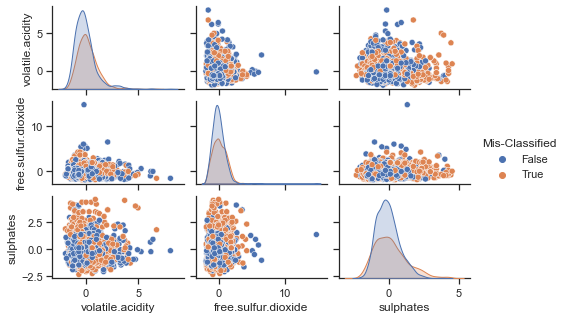

In [62]:
flat_priors_qda = QDA(train[["volatile.acidity", "free.sulfur.dioxide", "sulphates", "wine_quality"]], 'wine_quality')
flat_priors_qda.misclass_pairplot()

Now we must inspect the top 10 combinations for the best (lowest) testing error.

In [63]:
df_error_rates_combinations_qda.sort_values(by="testing error").head(10)

,combinations,training error,testing error
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.463814,0.451163
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.426998,0.454070
68,"volatile.acidity,free.sulfur.dioxide,pH",0.465387,0.472674
78,"volatile.acidity,pH,sulphates",0.462555,0.481977
67,"volatile.acidity,free.sulfur.dioxide,density",0.481435,0.484302
7,"fixed.acidity,volatile.acidity,sulphates",0.475456,0.495349
153,"free.sulfur.dioxide,pH,alcohol",0.521397,0.495349
54,"volatile.acidity,residual.sugar,free.sulfur.di...",0.470736,0.495930
154,"free.sulfur.dioxide,sulphates,alcohol",0.525488,0.496512
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.474198,0.499419


The best performing combination was volatile.acidity,residual.sugar,alcohol with a training error of 0.463814	. Comparing this with LDA with the dataframe shown below.

In [64]:
df_error_rates_combinations.sort_values(by="testing error").head(10)

,combinations,training error,testing error
77,"volatile.acidity,density,alcohol",0.510699,0.487791
59,"volatile.acidity,residual.sugar,alcohol",0.505035,0.488372
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.523285,0.500581
80,"volatile.acidity,sulphates,alcohol",0.524229,0.501163
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.523600,0.505814
65,"volatile.acidity,chlorides,alcohol",0.525488,0.511628
8,"fixed.acidity,volatile.acidity,alcohol",0.528005,0.513953
52,"volatile.acidity,citric.acid,alcohol",0.523285,0.515116
79,"volatile.acidity,pH,alcohol",0.520453,0.515698
56,"volatile.acidity,residual.sugar,density",0.526432,0.519186


We can see that the top 10 combinations are not overlapping although some are overlapping.

The pair plots for misclassification for the top combination is shown below.

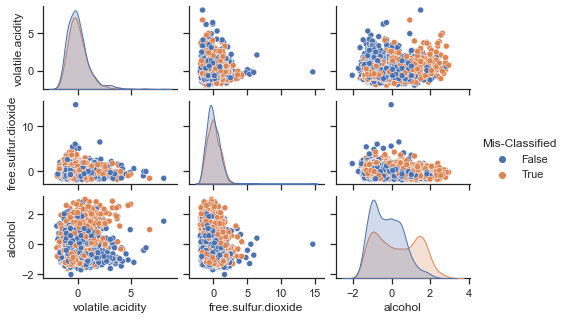

In [65]:
flat_priors_qda = QDA(train[["volatile.acidity", "free.sulfur.dioxide", "alcohol", "wine_quality"]], 'wine_quality')
flat_priors_qda.misclass_pairplot()

#### Q4-B
(b) Using priors that reflect the observed proportion of wine quality in the training dataset, identify the
combination of three features that provide the lowest mis-classification rate. Do the best models
differ from when you used flat priors?

In [66]:
error_rates_combinations_prop_qda = []
proportion = train["wine_quality"].value_counts(normalize=True)
reorder_prop = [proportion[2], proportion[0], proportion[1]]
for i in itertools.combinations(train.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    prop_priors_Qda = QDA(train[combination], 'wine_quality',priors=reorder_prop)
    training_error = prop_priors_Qda.misclass_rate()
    testing_error = prop_priors_Qda.misclass_rate(data = test[combination])
    error_rates_combinations_prop_qda.append([",".join(combination[:-1]), training_error, testing_error])
df_error_rates_combinations_prop_qda = pd.DataFrame(error_rates_combinations_prop_qda)
df_error_rates_combinations_prop_qda.columns = ["combinations", "training error", "testing error"]
df_error_rates_combinations_prop_qda

,combinations,training error,testing error
0,"fixed.acidity,volatile.acidity,citric.acid",0.335431,0.385465
1,"fixed.acidity,volatile.acidity,residual.sugar",0.339207,0.397674
2,"fixed.acidity,volatile.acidity,chlorides",0.329767,0.396512
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.337004,0.391279
4,"fixed.acidity,volatile.acidity,total.sulfur.di...",0.335746,0.395930
...,...,...,...
160,"total.sulfur.dioxide,sulphates,alcohol",0.326306,0.368023
161,"density,pH,sulphates",0.353367,0.429651
162,"density,pH,alcohol",0.329138,0.354651
163,"density,sulphates,alcohol",0.329138,0.369767


Lets take the top 10 for training error. 

In [67]:
df_error_rates_combinations_prop_qda.sort_values(by="training error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.273757,0.315116
77,"volatile.acidity,density,alcohol",0.276589,0.318023
80,"volatile.acidity,sulphates,alcohol",0.276904,0.326163
8,"fixed.acidity,volatile.acidity,alcohol",0.277533,0.319186
52,"volatile.acidity,citric.acid,alcohol",0.277848,0.325000
79,"volatile.acidity,pH,alcohol",0.278162,0.323837
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.279736,0.324419
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.284456,0.326744
16,"fixed.acidity,citric.acid,alcohol",0.290434,0.339535
98,"citric.acid,free.sulfur.dioxide,alcohol",0.294840,0.346512


We will compare this with LDA at the end of the question. We should now look at top 10 for testing error.

In [68]:
df_error_rates_combinations_prop_qda.sort_values(by="testing error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.273757,0.315116
77,"volatile.acidity,density,alcohol",0.276589,0.318023
8,"fixed.acidity,volatile.acidity,alcohol",0.277533,0.319186
79,"volatile.acidity,pH,alcohol",0.278162,0.323837
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.279736,0.324419
52,"volatile.acidity,citric.acid,alcohol",0.277848,0.325000
80,"volatile.acidity,sulphates,alcohol",0.276904,0.326163
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.284456,0.326744
16,"fixed.acidity,citric.acid,alcohol",0.290434,0.339535
56,"volatile.acidity,residual.sugar,density",0.295469,0.343605


Interestingly the best performing combination was volatile.acidity,residual.sugar,alcohol for both testing and training! We can look at the pair plot misclassifcation for this specific combination.

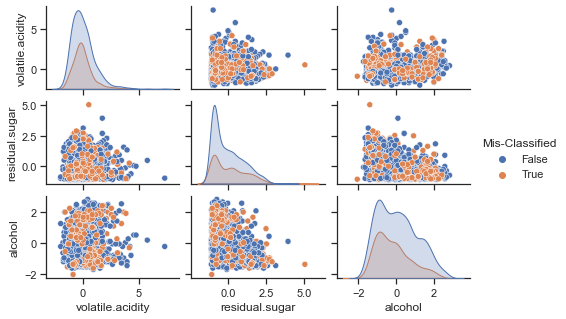

In [69]:
prop_priors_Qda = QDA(train[["volatile.acidity","residual.sugar", "alcohol", "wine_quality"]], 'wine_quality',priors=reorder_prop)
prop_priors_Qda.misclass_pairplot(data = test[["volatile.acidity","residual.sugar", "alcohol", "wine_quality"]])

## Q4-Extra Inspection
Let's simply look at both the best combination for QDA and LDA for training and testing errors.

In [70]:
## LDA
df_error_rates_combinations.sort_values(by="training error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.505035,0.488372
77,"volatile.acidity,density,alcohol",0.510699,0.487791
79,"volatile.acidity,pH,alcohol",0.520453,0.515698
52,"volatile.acidity,citric.acid,alcohol",0.523285,0.515116
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.523285,0.500581
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.523600,0.505814
80,"volatile.acidity,sulphates,alcohol",0.524229,0.501163
65,"volatile.acidity,chlorides,alcohol",0.525488,0.511628
56,"volatile.acidity,residual.sugar,density",0.526432,0.519186
8,"fixed.acidity,volatile.acidity,alcohol",0.528005,0.513953


In [71]:
## QDA
df_error_rates_combinations_qda.sort_values(by="training error").head(10)

,combinations,training error,testing error
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.426998,0.454070
78,"volatile.acidity,pH,sulphates",0.462555,0.481977
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.463814,0.451163
68,"volatile.acidity,free.sulfur.dioxide,pH",0.465387,0.472674
54,"volatile.acidity,residual.sugar,free.sulfur.di...",0.470736,0.495930
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.474198,0.499419
7,"fixed.acidity,volatile.acidity,sulphates",0.475456,0.495349
67,"volatile.acidity,free.sulfur.dioxide,density",0.481435,0.484302
118,"residual.sugar,free.sulfur.dioxide,sulphates",0.488987,0.515116
152,"free.sulfur.dioxide,pH,sulphates",0.493707,0.516279


In [72]:
## LDA - proportion prior
df_error_rates_combinations_prop.sort_values(by="training error").head(10)

,combinations,training error,testing error
80,"volatile.acidity,sulphates,alcohol",0.280050,0.331977
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.280365,0.336628
79,"volatile.acidity,pH,alcohol",0.280994,0.333140
65,"volatile.acidity,chlorides,alcohol",0.282253,0.337791
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.282253,0.337791
77,"volatile.acidity,density,alcohol",0.282253,0.330233
52,"volatile.acidity,citric.acid,alcohol",0.282568,0.334302
59,"volatile.acidity,residual.sugar,alcohol",0.282882,0.329651
8,"fixed.acidity,volatile.acidity,alcohol",0.283826,0.331977
56,"volatile.acidity,residual.sugar,density",0.301762,0.359884


In [73]:
## QDA - proportion prior
df_error_rates_combinations_prop_qda.sort_values(by="training error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.273757,0.315116
77,"volatile.acidity,density,alcohol",0.276589,0.318023
80,"volatile.acidity,sulphates,alcohol",0.276904,0.326163
8,"fixed.acidity,volatile.acidity,alcohol",0.277533,0.319186
52,"volatile.acidity,citric.acid,alcohol",0.277848,0.325000
79,"volatile.acidity,pH,alcohol",0.278162,0.323837
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.279736,0.324419
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.284456,0.326744
16,"fixed.acidity,citric.acid,alcohol",0.290434,0.339535
98,"citric.acid,free.sulfur.dioxide,alcohol",0.294840,0.346512


In [74]:
## LDA - Test
df_error_rates_combinations.sort_values(by="testing error").head(10)

,combinations,training error,testing error
77,"volatile.acidity,density,alcohol",0.510699,0.487791
59,"volatile.acidity,residual.sugar,alcohol",0.505035,0.488372
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.523285,0.500581
80,"volatile.acidity,sulphates,alcohol",0.524229,0.501163
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.523600,0.505814
65,"volatile.acidity,chlorides,alcohol",0.525488,0.511628
8,"fixed.acidity,volatile.acidity,alcohol",0.528005,0.513953
52,"volatile.acidity,citric.acid,alcohol",0.523285,0.515116
79,"volatile.acidity,pH,alcohol",0.520453,0.515698
56,"volatile.acidity,residual.sugar,density",0.526432,0.519186


In [75]:
## QDA - Test
df_error_rates_combinations_qda.sort_values(by="testing error").head(10)

,combinations,training error,testing error
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.463814,0.451163
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.426998,0.454070
68,"volatile.acidity,free.sulfur.dioxide,pH",0.465387,0.472674
78,"volatile.acidity,pH,sulphates",0.462555,0.481977
67,"volatile.acidity,free.sulfur.dioxide,density",0.481435,0.484302
7,"fixed.acidity,volatile.acidity,sulphates",0.475456,0.495349
153,"free.sulfur.dioxide,pH,alcohol",0.521397,0.495349
54,"volatile.acidity,residual.sugar,free.sulfur.di...",0.470736,0.495930
154,"free.sulfur.dioxide,sulphates,alcohol",0.525488,0.496512
3,"fixed.acidity,volatile.acidity,free.sulfur.dio...",0.474198,0.499419


In [76]:
## LDA - proportion prior - test
df_error_rates_combinations_prop.sort_values(by="testing error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.282882,0.329651
77,"volatile.acidity,density,alcohol",0.282253,0.330233
8,"fixed.acidity,volatile.acidity,alcohol",0.283826,0.331977
80,"volatile.acidity,sulphates,alcohol",0.280050,0.331977
79,"volatile.acidity,pH,alcohol",0.280994,0.333140
52,"volatile.acidity,citric.acid,alcohol",0.282568,0.334302
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.280365,0.336628
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.282253,0.337791
65,"volatile.acidity,chlorides,alcohol",0.282253,0.337791
56,"volatile.acidity,residual.sugar,density",0.301762,0.359884


In [77]:
## QDA - proportion prior - Test
df_error_rates_combinations_prop_qda.sort_values(by="testing error").head(10)

,combinations,training error,testing error
59,"volatile.acidity,residual.sugar,alcohol",0.273757,0.315116
77,"volatile.acidity,density,alcohol",0.276589,0.318023
8,"fixed.acidity,volatile.acidity,alcohol",0.277533,0.319186
79,"volatile.acidity,pH,alcohol",0.278162,0.323837
70,"volatile.acidity,free.sulfur.dioxide,alcohol",0.279736,0.324419
52,"volatile.acidity,citric.acid,alcohol",0.277848,0.325000
80,"volatile.acidity,sulphates,alcohol",0.276904,0.326163
74,"volatile.acidity,total.sulfur.dioxide,alcohol",0.284456,0.326744
16,"fixed.acidity,citric.acid,alcohol",0.290434,0.339535
56,"volatile.acidity,residual.sugar,density",0.295469,0.343605
